In [1]:
import uuid, sys, os
import requests
import random
import pandas as pd
import math
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats

from transformers import EsmModel, AutoTokenizer # huggingface
import esm

import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
torch.manual_seed(0)
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW
from accelerate import Accelerator
import training_utils.partitioning_utils as pat_utils
from torch.utils.checkpoint import checkpoint

# LoRA
from peft import LoraConfig, get_peft_model

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Tesla V100-SXM2-32GB


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
print("PyTorch:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.9.1+cu128
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [3]:
requests.get("https://api.wandb.ai/status").status_code

import wandb
wandb.login(key="f8a6d759fe657b095d56bddbdb4d586dfaebd468", relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /zhome/c9/0/203261/.netrc
wandb: Currently logged in as: s232958 (s232958-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
### Setting a seed to have the same initiation of weights

def set_seed(seed: int = 0):
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU

    # CuDNN settings (for convolution etc.)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # (Optional) for some Python hashing randomness
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 0
set_seed(SEED)

In [5]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing

seq_embed_dimension = 1280 #| 960 | 1152
# struct_embed_dimension = 256
number_of_recycles = 2
padding_value = -5000

In [6]:
# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


In [7]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

def non_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings > (padding_value + offset)).all(dim=-1)

### Loading Data for Model Training

In [8]:
Df_train = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_train_w_pbd_lens.csv",index_col=0).reset_index(drop=True)
Df_test = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_test_w_pbd_lens.csv",index_col=0).reset_index(drop=True)

Df_train["target_chain"] = [str(row.ID1[:5]+row.ID1[-1]) for __, row in Df_train.iterrows()]
Df_train["binder_chain"] = [str(row.ID2[:5]+row.ID2[-1]) for __, row in Df_train.iterrows()]

Df_test["target_chain"] = [str(row.ID1[:5]+row.ID1[-1]) for __, row in Df_test.iterrows()]
Df_test["binder_chain"] = [str(row.ID2[:5]+row.ID2[-1]) for __, row in Df_test.iterrows()]

Df_train

,interface_id,PDB,ID1,ID2,seq_target,seq_target_len,seq_pdb_target,pdb_target_len,target_chain,seq_binder,seq_binder_len,seq_pdb_binder,pdb_binder_len,binder_chain,pdb_path
0,6IDB_0,6IDB,6IDB_0_A,6IDB_0_B,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,317,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,317,6IDB_A,GLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAID...,172,GLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAID...,172,6IDB_B,6idb.pdb.gz
1,2WZP_3,2WZP,2WZP_3_D,2WZP_3_G,VQLQESGGGLVQAGGSLRLSCTASRRTGSNWCMGWFRQLAGKEPEL...,122,VQLQESGGGLVQAGGSLRLSCTASRRTGSNWCMGWFRQLAGKEPEL...,122,2WZP_D,TIKNFTFFSPNSTEFPVGSNNDGKLYMMLTGMDYRTIRRKDWSSPL...,266,TIKNFTFFSPNSTEFPVGSNNDGKLYMMLTGMDYRTIRRKDWSSPL...,266,2WZP_G,2wzp.pdb.gz
2,1ZKP_0,1ZKP,1ZKP_0_A,1ZKP_0_C,LYFQSNAKTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGVLA...,246,LYFQSNAMKMTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGV...,251,1ZKP_A,AKTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGVLAQLQKYI...,240,AMKMTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGVLAQLQK...,245,1ZKP_C,1zkp.pdb.gz
3,6GRH_3,6GRH,6GRH_3_C,6GRH_3_D,SKHELSLVEVTHYTDPEVLAIVKDFHVRGNFASLPEFAERTFVSAV...,266,SKHELSLVEVTHYTDPEVLAIVKDFHVRGNFASLPEFAERTFVSAV...,266,6GRH_C,MINVYSNLMSAWPATMAMSPKLNRNMPTFSQIWDYERITPASAAGE...,396,MINVYSNLMSAWPATMAMSPKLNRNMPTFSQIWDYERITPASAAGE...,396,6GRH_D,6grh.pdb.gz
4,8R57_1,8R57,8R57_1_M,8R57_1_f,DLMTALQLVMKKSSAHDGLVKGLREAAKAIEKHAAQICVLAEDCDQ...,118,DLMTALQLVMKKSSAHDGLVKGLREAAKAIEKHAAQICVLAEDCDQ...,118,8R57_M,PKKQKHKHKKVKLAVLQFYKVDDATGKVTRLRKECPNADCGAGTFM...,64,PKKQKHKHKKVKLAVLQFYKVDDATGKVTRLRKECPNADCGAGTFM...,64,8R57_f,8r57.pdb.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,4YO8_0,4YO8,4YO8_0_A,4YO8_0_B,HENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNVFHKG...,238,HENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNVFHKG...,238,4YO8_A,HHHHHENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNV...,242,HHHHHENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNV...,242,4YO8_B,4yo8.pdb.gz
1973,3CKI_0,3CKI,3CKI_0_A,3CKI_0_B,DPMKNTCKLLVVADHRFYRYMGRGEESTTTNYLIELIDRVDDIYRN...,256,DPMKNTCKLLVVADHRFYRYMGRGEESTTTNYLIELIDRVDDIYRN...,256,3CKI_A,CTCSPSHPQDAFCNSDIVIRAKVVGKKLVKEGPFGTLVYTIKQMKM...,121,CTCSPSHPQDAFCNSDIVIRAKVVGKKLVKEGPFGTLVYTIKQMKM...,121,3CKI_B,3cki.pdb.gz
1974,7MHY_1,7MHY,7MHY_1_M,7MHY_1_N,QVQLRQSGAELAKPGASVKMSCKASGYTFTNYWLHWIKQRPGQGLE...,118,QVQLRQSGAELAKPGASVKMSCKASGYTFTNYWLHWIKQRPGQGLE...,118,7MHY_M,DVLMTQTPLSLPVSLGDQVSISCRSSQSIVHNTYLEWYLQKPGQSP...,109,DVLMTQTPLSLPVSLGDQVSISCRSSQSIVHNTYLEWYLQKPGQSP...,109,7MHY_N,7mhy.pdb.gz
1975,7MHY_2,7MHY,7MHY_2_O,7MHY_2_P,IQLVQSGPELVKISCKASGYTFTNYGMNWVRQAPGKGLKWMGWINT...,100,IQLVQSGPELVKISCKASGYTFTNYGMNWVRQAPGKGLKWMGWINT...,100,7MHY_O,VLMTQTPLSLPVSISCRSSQSIVHSNGNTYLEWYLQKPGQSPKLLI...,94,VLMTQTPLSLPVSISCRSSQSIVHSNGNTYLEWYLQKPGQSPKLLI...,94,7MHY_P,7mhy.pdb.gz


In [9]:
Df_train[Df_train.ID1.str.startswith("3HU6")].seq_target.item()

'SKVVKFSYMWTINNFSFCREEMGEVIKSSTFSSKLKWCLRVNPKGLDSKDYLSLYLLLVSCPKEVRAKFKFSILNAKGEETKAMESQRAYRFVQGKDWGFKKFIRRGFLLDEANGLLPDDKLTLFCEVSVVQDSQTMNMVKVPECRLADELGGLWENSRFTDCCLCVAGQEFQAHKAILAARSPVFSAMFEHKNRVEINDVEPEVFKEMMCFIYTGKAPNLDKMADDLLAAADKYALERLKVMCEDALCSNLSVENAAEILILADLHSADQLKTQAVDFINYHA'

In [10]:
train_Df1 = Df_train[["target_chain", "seq_pdb_target", "pdb_target_len"]].rename(columns = {
    "seq_pdb_target" : "sequence",
    "target_chain" : "ID",
    "pdb_target_len": "seq_len",
})

train_Df2 = Df_train[["binder_chain", "seq_pdb_binder", "pdb_binder_len"]].rename(columns = {
    "seq_pdb_binder" : "sequence",
    "binder_chain" : "ID",
    "pdb_binder_len": "seq_len",
})

Df_train_LONG = pd.concat([train_Df1, train_Df2], axis=0, ignore_index=True).drop_duplicates(subset="ID", keep="first")
Df_train_LONG

,ID,sequence,seq_len
0,6IDB_A,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,317
1,2WZP_D,VQLQESGGGLVQAGGSLRLSCTASRRTGSNWCMGWFRQLAGKEPEL...,122
2,1ZKP_A,LYFQSNAMKMTVVGFWGGFPEAGEATSGYLFEHDGFRLLVDCGSGV...,251
3,6GRH_C,SKHELSLVEVTHYTDPEVLAIVKDFHVRGNFASLPEFAERTFVSAV...,266
4,8R57_M,DLMTALQLVMKKSSAHDGLVKGLREAAKAIEKHAAQICVLAEDCDQ...,118
...,...,...,...
3949,4YO8_B,HHHHHENLYFQGVQKIGILGAMREEITPILELFGVDFEEIPLGGNV...,242
3950,3CKI_B,CTCSPSHPQDAFCNSDIVIRAKVVGKKLVKEGPFGTLVYTIKQMKM...,121
3951,7MHY_N,DVLMTQTPLSLPVSLGDQVSISCRSSQSIVHNTYLEWYLQKPGQSP...,109
3952,7MHY_P,VLMTQTPLSLPVSISCRSSQSIVHSNGNTYLEWYLQKPGQSPKLLI...,94


In [11]:
test_Df1 = Df_test[["target_chain", "seq_pdb_target", "pdb_target_len"]].rename(columns = {
    "seq_pdb_target" : "sequence",
    "target_chain" : "ID",
    "pdb_target_len": "seq_len",
})

test_Df2 = Df_test[["binder_chain", "seq_pdb_binder", "pdb_binder_len"]].rename(columns = {
    "seq_pdb_binder" : "sequence",
    "binder_chain" : "ID",
    "pdb_binder_len": "seq_len",
})

Df_test_LONG = pd.concat([test_Df1, test_Df2], axis=0, ignore_index=True).drop_duplicates(subset="ID", keep="first")
Df_test_LONG

,ID,sequence,seq_len
0,1NNW_A,VYVAVLANIAGNLPALTAALSRIEEMREEGYEIEKYYILGNIVGLF...,251
1,3UCN_A,TADLSPLLEANRKWADECAAKDSTYFSKVAGSQAPEYLYIGCADSR...,222
2,1POV_1,QHRSRSESSIESFFARGACVTIMTVDNPASTTNKDKLFAVWKITYK...,235
3,3R6Y_C,VRIEKDFLGEKEIPKDAYYGVQTIRATENFPITGYRIHPELIKSLG...,383
4,5YHI_A,PMRYPVDVYTGKIQVDGELMLTELGLEGDGPDRALCHYPREHYLYW...,202
...,...,...,...
983,3GXE_F,GLPGMKGHRGF,11
984,6LY5_l,ANFIKPYNDDPFVGHLATPITSSAVTRSLLKNLPAYRFGLTPLLRG...,144
985,5MLK_B,ARISKVLVANRGEIAVRVIRAARDAGLPSVAVYAEPDAESPHVRLA...,384
986,8BS4_B,GHPVLEKLKAAHSYNPKEFEWNLKSGRVFIIKSYSEDDIHRSIKYS...,193


#### Loading seqeunce, structural_embeddings & using pooled embeddings for CLIP (PPint)

In [12]:
class CLIP_PPint_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim_struct=512,
        embedding_dim_seq=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = embedding_dim_seq
        self.embedding_dim_struct = embedding_dim_struct
        self.emb_pad = embedding_pad_value

        # lengths
        self.max_len = self.dframe["seq_len"].max()+2

        # paths
        self.seq_encodings_path, self.struct_encodings_path = paths

        # index & storage
        self.dframe.set_index("ID", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):

            # laod embeddings
            emb_struct = np.load(os.path.join(self.struct_encodings_path, f"{accession}.npy"))[1:-1, :] # remove EOS BOS, to use only real aa token for cos-sim
            sequence = self.dframe.loc[accession].sequence

            if len(sequence) != emb_struct.shape[0]:
                print(sequence, emb_struct.shape[0])

            if emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            if emb_struct.shape[0] < self.max_len:
                emb_struct = np.concatenate([emb_struct, np.full((self.max_len - emb_struct.shape[0], emb_struct.shape[1]), self.emb_pad, dtype=emb_struct.dtype)], axis=0)
            else:
                emb_struct = emb_struct[: self.max_len] # no padding was used

            self.samples.append((sequence, emb_struct))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sequence, emb_struct = self.samples[idx]
        emb_struct = torch.from_numpy(emb_struct).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe        
        return sequence, emb_struct, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        # emb_seq_list, emb_struct_list, label_list = zip(*out)
        sequence_list, emb_struct_list, lbl_list = zip(*out)
    
        # Stack embeddings    
        emb_struct_stacked  = torch.stack([torch.as_tensor(x) for x in emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        lbl_stacked = torch.stack(lbl_list)  # [B]
    
        return list(sequence_list), emb_struct_stacked, lbl_stacked

emb_seq_path = "/work3/s232958/data/PPint_DB/embeddings_esm2"
emb_struct_path = "/work3/s232958/data/PPint_DB/esmif_embeddings_noncanonical"

train_Dataset = CLIP_PPint_w_esmIF(
    Df_train_LONG,
    paths=[emb_seq_path, emb_struct_path],
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

test_Dataset = CLIP_PPint_w_esmIF(
    Df_test_LONG,
    paths=[emb_seq_path, emb_struct_path],
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

#Loading ESM2 embeddings and contacts: 100%|█████████████████████████████████████████| 985/985 [00:02<00:00, 408.56it/s]


#### Loading seqeunce, structural_embeddings & using pooled embeddings for CLIP (meta-anlaysis dataset)

In [13]:
meta_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal_w_pbd_lens.csv").drop(columns = ["binder_id", "target_id"]).rename(columns = {
    "target_id_mod" : "target_id",
    "target_binder_ID" : "binder_id",
})

meta_df["target_id_mod"] = [str("t_"+row.target_id) for __, row in meta_df.iterrows()]

# Interaction Dict
meta_df_shuffled = meta_df.sample(frac=1, random_state=0).reset_index(drop=True)

meta_df_shuffled_LONG_binder = meta_df_shuffled[["binder_id", "binder_seq", "seq_len_binder"]].rename(columns = {
    "binder_id" : "ID",
    "binder_seq" : "sequence",
    "seq_len_binder": "seq_len",
})

meta_df_shuffled_LONG_taget = meta_df_shuffled[["target_id_mod", "target_seq", "seq_len_target"]].rename(columns = {
    "target_id_mod" : "ID",
    "target_seq" : "sequence",
    "seq_len_target": "seq_len",
}).drop_duplicates(subset="ID", keep="first")

meta_df_shuffled_LONG = pd.concat([meta_df_shuffled_LONG_binder, meta_df_shuffled_LONG_taget], axis=0, ignore_index=True)
meta_sample_Df = meta_df_shuffled_LONG.sample(n=len(Df_test_LONG), random_state=0).reset_index(drop=True)
meta_df_shuffled_LONG

,ID,sequence,seq_len
0,FGFR2_124,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,62
1,EGFR_2_149,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,58
2,FGFR2_339,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,65
3,FGFR2_1234,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,64
4,IL2Ra_48,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,65
...,...,...,...
3543,t_SARS_CoV2_RBD,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,195
3544,t_VirB8,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,138
3545,t_sntx_2,MICHNQQSSQPPTTKTCSEGQCYKKTWRDHRGTIIERGCGCPTVKP...,60
3546,t_sntx,MICYNQQSSQPPTTKTCSETSCYKKTWRDHRGTIIERGCGCPKVKP...,60


In [14]:
class CLIP_Meta_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        embedding_dim_struct=512,
        embedding_dim_seq=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = embedding_dim_seq
        self.embedding_dim_struct = embedding_dim_struct
        self.emb_pad = embedding_pad_value

        # lengths
        self.max_len = self.dframe["seq_len"].max()

        # index & storage
        
        self.dframe.set_index("ID", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            
            if accession.startswith("t_"):
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"
                
                # emb_struct = np.load(os.path.join(esmIF_path, f"{accession[2:]}.npy"))
                emb_struct = np.load(os.path.join(esmIF_path, f"{accession[2:]}.npy"))[1:-1, :] # remove EOS BOS, to use only real aa token for cos-sim
                sequence = str(self.dframe.loc[accession].sequence)

            else:
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"

                # emb_struct = np.load(os.path.join(esmIF_path, f"{accession}.npy"))     # [Lb, D]
                emb_struct = np.load(os.path.join(esmIF_path, f"{accession}.npy"))[1:-1, :] # remove EOS BOS, to use only real aa token for cos-sim
                sequence = str(self.dframe.loc[accession].sequence)            

            if len(sequence) != emb_struct.shape[0]:
                print(str(sequence), len(sequence), emb_struct.shape[0])

            if emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            if emb_struct.shape[0] < self.max_len:
                emb_struct = np.concatenate([emb_struct, np.full((self.max_len - emb_struct.shape[0], emb_struct.shape[1]), self.emb_pad, dtype=emb_struct.dtype)], axis=0)
            else:
                emb_struct = emb_struct[: self.max_len] # no padding was used

            self.samples.append((sequence, emb_struct))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sequence, emb_struct = self.samples[idx]
        emb_struct = torch.from_numpy(emb_struct).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe        
        return sequence, emb_struct, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        # emb_seq_list, emb_struct_list, label_list = zip(*out)
        sequence_list, emb_struct_list, lbl_list = zip(*out)
    
        # Stack embeddings    
        emb_struct_stacked  = torch.stack([torch.as_tensor(x) for x in emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        lbl_stacked = torch.stack(lbl_list)  # [B]
    
        return list(sequence_list), emb_struct_stacked, lbl_stacked

esm2_path_binders = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
esm2_path_targets = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"

## Contact maps paths
esmIF_path_binders = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"
esmIF_path_targets = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"

# meta_Dataset_train = CLIP_Meta_w_esmIF(
#     meta_df_shuffled_LONG_train,
#     embedding_dim_seq=1280,
#     embedding_dim_struct=512
# )

meta_Dataset = CLIP_Meta_w_esmIF(
    meta_sample_Df,
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

#Loading ESM2 embeddings and contacts: 100%|█████████████████████████████████████████| 985/985 [00:01<00:00, 559.51it/s]


### Contrastive Sequence-Structure Pre-training (CSSP)
- token-lvl cos-siminilarity
- loading seq_encoder/seq_down after 50 epochs and training longer

In [15]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [16]:
class CSSPBoostingESM(nn.Module):
    def __init__(self, seq_embed_dim=1280, struct_embed_dim=512, padding_value=-5000):
        super().__init__()
        self.padding_value = padding_value
        self.struct_embed_dim = 512
        self.seq_encoder = ESM2EncoderLoRA()
        self.seq_down = nn.Linear(seq_embed_dim, struct_embed_dim)  
        # self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))

    def forward(self, sequences, struct_embed):
    
        # ---- encode sequence ----
        seq_embed = self.seq_encoder(sequences)          # [B, Lseq, 1280]
        B, Lseq, _ = seq_embed.shape
        _, Lstr, D = struct_embed.shape                  # D = 512
    
        # ---- masks ----
        seq_mask = non_padding_mask(seq_embed, self.padding_value)      # True = real
        struct_mask = non_padding_mask(struct_embed, self.padding_value)  # True = real
    
        # enforce residue alignment
        assert (
            seq_mask.sum(dim=1).cpu().tolist()
            == struct_mask.sum(dim=1).cpu().tolist()
        ), "Sequence and structure residue counts do not match"
    
        # ---- project seq + pad to structure length ----
        seq_embed_proj = torch.full(
            (B, Lstr, D),
            self.padding_value,
            device=seq_embed.device,
            dtype=seq_embed.dtype,
        )
    
        for i in range(B):
            real_seq = seq_embed[i][seq_mask[i]]     # [Li, 1280]
            proj = self.seq_down(real_seq)            # [Li, 512]
            seq_embed_proj[i, :proj.size(0)] = proj   # align positions
    
        # seq_pooled = create_mean_of_non_masked(seq_embed_proj, create_key_padding_mask(seq_embed_proj))
        # struct_pooled = create_mean_of_non_masked(struct_embed, create_key_padding_mask(struct_embed))
    
        # seq_full = F.normalize(seq_pooled, dim=-1)
        # struct_full = F.normalize(struct_pooled, dim=-1)
    
        # scale = torch.exp(self.logit_scale).clamp(max=100)
        # logits_seq = scale * (seq_full @ struct_full.T)
        # logits_struct = scale * (struct_full @ seq_full.T)
    
        # return logits_seq, logits_struct, seq_embed_proj, struct_embed, struct_mask
        return seq_embed_proj, struct_embed, struct_mask

    def training_step(self, batch, device):
    
        sequences, struct_embed, _ = batch
        struct_embed = struct_embed.to(device)
    
        # logits_seq, logits_struct, seq_embed_proj, struct_embed, struct_mask = self.forward(sequences, struct_embed)
        seq_embed_proj, struct_embed, struct_mask = self.forward(sequences, struct_embed)
    
        # ---- CLIP loss ----
        # B = logits_seq.size(0)
        # labels = torch.arange(B, device=device)
    
        # loss_seq = F.cross_entropy(logits_seq, labels)
        # loss_struct = F.cross_entropy(logits_struct, labels)
        # clip_loss = 0.5 * (loss_seq + loss_struct)
    
        # ---- token-level cosine loss (aligned positions) ----
        cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Lstr]
        cos = cos * struct_mask.float()                                   # mask padding
    
        per_token_loss = 1.0 - (cos.sum(dim=1) / struct_mask.sum(dim=1)).mean()
    
        # return clip_loss + 0.5 * per_token_loss
        return per_token_loss

In [17]:
model = CSSPBoostingESM(
    seq_embed_dim=1280,
    struct_embed_dim=512,
    padding_value=-5000,
).to(device)

# model

runID = uuid.uuid4()
learning_rate = 2e-5
EPOCHS = 50
batch_size = 10
model = CSSPBoostingESM(seq_embed_dim=1280, struct_embed_dim=512).to("cuda")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# optimizer = AdamW(model.parameters(), lr=learning_rate)
seq_down_params = set(model.seq_down.parameters())
other_params = [p for p in model.parameters() if p not in seq_down_params]
optimizer = torch.optim.AdamW([
    {"params": other_params, "lr": learning_rate},
    {"params": model.seq_down.parameters(),"lr": 2e-6},
])

accelerator = Accelerator()
device = accelerator.device

train_dataloader = DataLoader(train_Dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_Dataset, batch_size=10, shuffle=False)
val_dataloader = DataLoader(meta_Dataset, batch_size=10, shuffle=False)

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# model.eval()
# cosine_similarities, all_embeds = [], []
# with torch.no_grad():
#     for batch in tqdm(test_dataloader, total = len(test_dataloader)):
#         seqs, struct_embed, labels = batch
#         struct_embed = struct_embed.to(device)      # [B, Ls, 512]

#         # ---- sequence embeddings ----
#         seq_embed = model.seq_encoder(seqs)         # [B, Lq, 1280]
#         B, Lq, _ = seq_embed.shape
#         _, Ls, Ds = struct_embed.shape

#         seq_mask = non_padding_mask(seq_embed, model.padding_value)   # [B, Lq]
#         str_mask = non_padding_mask(struct_embed, model.padding_value)  # [B, Ls]

#         # enforce residue-wise alignment
#         assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())
#         print(seq_mask.shape, str_mask.shape)
#         # print(seq_mask.sum(dim=1).cpu().tolist())
#         # print(str_mask.sum(dim=1).cpu().tolist())

#         # ---- project seq tokens + pad to structure length ----
#         seq_embed_proj = torch.full((B, Ls, Ds), model.padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
#         # print(seq_embed_proj.shape)
        
#         for i in range(B):
#             real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
#             proj = model.seq_down(real_seq)      # [Li, 512]
#             seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls

#         # ---- token-level cosine similarity (aligned positions) ----
#         assert (seq_embed_proj.shape[1]== struct_embed.shape[1])
#         cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
#         print(cos[0])
#         cos = cos * str_mask.float()   # mask padding
#         print(cos[0])

#         per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
#         cosine_similarities.extend(per_seq_cos.cpu().tolist())

#         # ---- pooled sequence embeddings (projected space) ----
#         seq_pooled = create_mean_of_non_masked(seq_embed_proj, create_key_padding_mask(seq_embed_proj))
#         seq_full = F.normalize(seq_pooled, dim=-1)
#         all_embeds.append(seq_full.cpu())
#         break

In [22]:
"""
- token-lvl cos-siminilarity
- train seq_down for 5 epochs and then freeze all parameters
- train in total for 50 epochs, save model every 5 epochs and plot progress in W&B
"""

class TrainWrapper():

    def __init__(
        self,
        model=model,
        train_loader=train_dataloader,
        test_loader=test_dataloader,
        val_loader=val_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=device,
        wandb_tracker=False,
        save_at = []
    ):
        self.model = model
        self.training_loader = train_loader
        self.testing_loader = test_loader
        self.validation_loader = val_loader
        self.EPOCHS = epochs
        self.optimizer = optimizer
        self.device = device
        self.wandb_tracker = wandb_tracker
        self.save_at = set(save_at)

    def train_one_epoch(self):

        self.model.train()
        self.model.seq_encoder.train()

        running_loss = 0

        for batch in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):

            sequences, struct_embed, labels = batch
            struct_embed = struct_embed.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            loss = self.model.training_step((sequences, struct_embed, labels), self.device)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

        return running_loss / len(self.training_loader)
    

    @torch.no_grad()
    def compute_embeddings_cos_similariy(self, loader=None, loader_name="test"):
    
        if loader is None:
            loader = self.testing_loader
    
        self.model.eval()
        self.model.seq_encoder.eval()
    
        all_embeds = []
        cosine_similarities = []
    
        for batch in tqdm(loader, desc=f"Computing cosine similarity & embeddings ({loader_name})"):
    
            seqs, struct_embed, _ = batch
            struct_embed = struct_embed.to(self.device)      # [B, Ls, 512]
    
            # ---- sequence embeddings ----
            seq_embed = self.model.seq_encoder(seqs)         # [B, Lq, 1280]
            B, Lq, _ = seq_embed.shape
            _, Ls, Ds = struct_embed.shape
    
            seq_mask = non_padding_mask(seq_embed, self.model.padding_value)   # [B, Lq]
            str_mask = non_padding_mask(struct_embed, self.model.padding_value)  # [B, Ls]
    
            # enforce residue-wise alignment
            assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())
    
            # ---- project seq tokens + pad to structure length ----
            seq_embed_proj = torch.full((B, Ls, Ds), self.model.padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
            for i in range(B):
                real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
                proj = self.model.seq_down(real_seq)      # [Li, 512]
                seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls
    
            # ---- token-level cosine similarity (aligned positions) ----
            cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
            cos = cos * str_mask.float()   # mask padding
    
            per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
            cosine_similarities.extend(per_seq_cos.cpu().tolist())
    
            # ---- pooled sequence embeddings (projected space) ----
            seq_pooled = create_mean_of_non_masked(seq_embed_proj, create_key_padding_mask(seq_embed_proj))
            seq_full = F.normalize(seq_pooled, dim=-1)
            all_embeds.append(seq_full.cpu())
    
        all_embeds = torch.cat(all_embeds, dim=0)
    
        avg_cos = float(np.mean(cosine_similarities))
        std_cos = float(np.std(cosine_similarities))
    
        return all_embeds, cosine_similarities, avg_cos, std_cos

    @torch.no_grad()
    def eval_train_loss(self):
        self.model.eval()
        running = 0.0
        for sequences, struct_embed, labels in tqdm(self.training_loader, total=len(self.training_loader), desc=f"Computing Training Loss before training"):
            struct_embed = struct_embed.to(self.device)
            labels = labels.to(self.device)
            loss = self.model.training_step((sequences, struct_embed, labels), self.device)
            running += loss.item()
        return running / len(self.training_loader)

    def plot_embeddings_drift_cos_similarity_change(self, start_embeddings, end_embeddings, cosine_similarities):

        drift = (end_embeddings - start_embeddings).norm(dim=1).cpu().numpy()
        cosine_similarities = np.array(cosine_similarities)

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        ax[0].hist(drift, bins=30, color="steelblue", alpha=0.8)
        ax[0].set_title("Embedding Drift per Sequence", fontsize=8)
        ax[0].set_xlabel("L2 Norm Drift", fontsize=8)
        ax[0].set_ylabel("Density", fontsize=8)

        ax[1].hist(cosine_similarities, bins=40, color="darkorange", alpha=0.7, density=True)
        ax[1].set_title("Cosine Similarities (ESM-2 vs ESM-IF)", fontsize=8)
        ax[1].set_xlabel("Cosine Similarity", fontsize=8)
        ax[1].set_ylabel("Density", fontsize=8)

        plt.tight_layout()
        plt.show()


    def train_model(self, save_every: int = 5):
    
        run_dir = f"/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/{runID}/"
        os.makedirs(run_dir, exist_ok=True)
    
        print("\nTrainable parameters inside seq_encoder (LoRA layers):")
        for name, p in self.model.seq_encoder.named_parameters():
            if p.requires_grad:
                print("  ", name)
    
        # ---- Save checkpoint BEFORE training (epoch 0) ----
        save_path_encoder = os.path.join(run_dir, "seq_encoder_before_training.pt")
        save_path_projhead = os.path.join(run_dir, "seq_down_before_training.pt")
        torch.save(self.model.seq_encoder.state_dict(), save_path_encoder)
        torch.save(self.model.seq_down.state_dict(), save_path_projhead)
        print(f"Saved seq_encoder checkpoint before training -> {save_path_encoder}")
        print(f"Saved proj head checkpoint before training -> {save_path_projhead}")
    
        # ---- START embeddings/cos-sim for both loaders ----
        print("Computing Loss before training:")
        train_loss = self.eval_train_loss()
        print(f"[TRAIN] Loss {train_loss}")
        
        print("\nExtracting START embeddings & cosine similarities (val + test)...")
        start_val_emb, start_val_cos, start_val_avg, start_val_std = self.compute_embeddings_cos_similariy(loader=self.validation_loader, loader_name="val")
        print(f"[VAL]  avg cos: {start_val_avg:.4f}, std: {start_val_std:.4f}")
        self.plot_embeddings_drift_cos_similarity_change(start_val_emb, start_val_emb, start_val_cos)
    
        start_test_emb, start_test_cos, start_test_avg, start_test_std = self.compute_embeddings_cos_similariy(loader=self.testing_loader, loader_name="test")
        print(f"[TEST] avg cos: {start_test_avg:.4f}, std: {start_test_std:.4f}")
        # self.plot_embeddings_drift_cos_similarity_change(start_test_emb, start_test_emb, start_test_cos)

        if self.wandb_tracker:
            self.wandb_tracker.log({
                "train/loss": train_loss,
                "val/cos_avg": start_val_avg,
                "val/cos_std": start_val_std,
                "test/cos_avg": start_test_avg,
                "test/cos_std": start_test_std,
            }, step=0)
    
        for epoch in range(1, self.EPOCHS + 1):
        
            if epoch == 5:
                print(f"\nFreezing projection head (seq_down) after {epoch-1} epoch(s), continuing training of the rest...")
                for p in self.model.seq_down.parameters():
                    p.requires_grad = False
                self.optimizer.zero_grad(set_to_none=True)
    
            train_loss = self.train_one_epoch()
            print(f"Epoch {epoch}: loss={train_loss:.4f}")
    
            # Optional: monitor cos-sim each epoch (val + test)
            val_emb, val_cos, val_avg, val_std = self.compute_embeddings_cos_similariy(loader=self.validation_loader, loader_name="val")
            print(f"[VAL]  avg cos: {val_avg:.4f}, std: {val_std:.4f}")
    
            test_emb, test_cos, test_avg, test_std = self.compute_embeddings_cos_similariy(loader=self.testing_loader, loader_name="test")
            print(f"[TEST] avg cos: {test_avg:.4f}, std: {test_std:.4f}")
            
            # ---- Save checkpoints when ----            
            value = round(val_avg, 2)
            if value in self.save_at:
                save_path_encoder = os.path.join(run_dir, f"seq_encoder_cos-sim{value}.pt")
                save_path_projhead = os.path.join(run_dir, f"seq_down_cos-sim{value}.pt")
                save_path_model = os.path.join(run_dir, f"model_cos-sim{value}.pt")
                torch.save(self.model.state_dict(), save_path_model)
                torch.save(self.model.seq_encoder.state_dict(), save_path_encoder)
                torch.save(self.model.seq_down.state_dict(), save_path_projhead)
                print(f"Saved whole model checkpoint -> {save_path_model}")
                print(f"Saved seq_encoder checkpoint -> {save_path_encoder}")
                print(f"Saved proj head checkpoint -> {save_path_projhead}")
                self.save_at.remove(value)

            if self.wandb_tracker:
                self.wandb_tracker.log({
                    "train/loss": train_loss,
                    "val/cos_avg": val_avg,
                    "val/cos_std": val_std,
                    "test/cos_avg": test_avg,
                    "test/cos_std": test_std,
                }, step=epoch)

            if len(self.save_at)==0:
                # ---- END embeddings/cos-sim for both loaders ----
                print("\nExtracting END embeddings & cosine similarities (val + test)...")
                end_val_emb, end_val_cos, val_avg, val_std = self.compute_embeddings_cos_similariy(loader=self.validation_loader, loader_name="val")
                print(f"[VAL]  avg cos: {val_avg:.4f}, std: {val_std:.4f}")
                self.plot_embeddings_drift_cos_similarity_change(start_val_emb, end_val_emb, end_val_cos)
        
                end_test_emb, end_test_cos, test_avg, test_std = self.compute_embeddings_cos_similariy(loader=self.testing_loader, loader_name="test")
                print(f"[TEST] avg cos: {test_avg:.4f}, std: {test_std:.4f}")
            
                # Return test triplet like your original expectation:
                return (start_val_emb, end_val_emb, end_val_cos), (start_test_emb, end_test_emb, end_test_cos)
    
        # ---- END embeddings/cos-sim for both loaders ----
        print("\nExtracting END embeddings & cosine similarities (val + test)...")
        end_val_emb, end_val_cos, val_avg, val_std = self.compute_embeddings_cos_similariy(loader=self.validation_loader, loader_name="val")
        print(f"[VAL]  avg cos: {val_avg:.4f}, std: {val_std:.4f}")
        self.plot_embeddings_drift_cos_similarity_change(start_val_emb, end_val_emb, end_val_cos)

        end_test_emb, end_test_cos, test_avg, test_std = self.compute_embeddings_cos_similariy(loader=self.testing_loader, loader_name="test")
        print(f"[TEST] avg cos: {test_avg:.4f}, std: {test_std:.4f}")
    
        # Return test triplet like your original expectation:
        return (start_val_emb, end_val_emb, end_val_cos), (start_test_emb, end_test_emb, end_test_cos)

In [23]:
# ### NExr:
# seq_down_params = set(model.seq_down.parameters())
# other_params = [p for p in model.parameters() if p not in seq_down_params]
# optimizer = torch.optim.AdamW([
#     {"params": other_params, "lr": learning_rate},
#     {"params": model.seq_down.parameters(),"lr": 2e-6},
# ])

# if epoch == 2:
#     print(f"\nFreezing projection head (seq_down) after {epoch-1} epoch(s), continuing training of the rest...")
#     for p in self.model.seq_down.parameters():
#         p.requires_grad = False
#     self.optimizer.zero_grad(set_to_none=True)


Trainable parameters inside seq_encoder (LoRA layers):
   model.base_model.model.encoder.layer.25.attention.self.query.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.query.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.self.key.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.key.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.self.value.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.self.value.lora_B.default.weight
   model.base_model.model.encoder.layer.25.attention.output.dense.lora_A.default.weight
   model.base_model.model.encoder.layer.25.attention.output.dense.lora_B.default.weight
   model.base_model.model.encoder.layer.25.intermediate.dense.lora_A.default.weight
   model.base_model.model.encoder.layer.25.intermediate.dense.lora_B.default.weight
   model.base_model.model.encoder.layer.25.output.dense.lora_A.default.weight
   model.b

Computing Training Loss before training: 100%|████████████████████████████████████████| 395/395 [03:30<00:00,  1.87it/s]


[TRAIN] Loss 1.0004106403906134

Extracting START embeddings & cosine similarities (val + test)...


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.69it/s]


[VAL]  avg cos: -0.0051, std: 0.0092


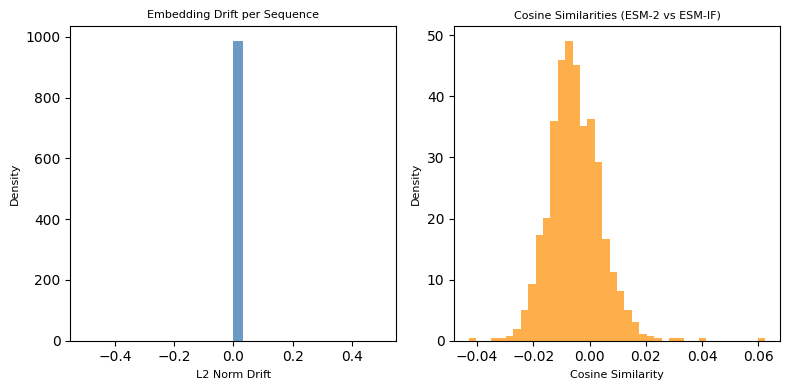

Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: -0.0006, std: 0.0088


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:40<00:00,  1.41it/s]


Epoch 1: loss=0.9691


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.68it/s]


[VAL]  avg cos: 0.0455, std: 0.0100


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:54<00:00,  1.83it/s]


[TEST] avg cos: 0.0626, std: 0.0134
Saved whole model checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/model_cos-sim0.05.pt
Saved seq_encoder checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.05.pt
Saved proj head checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.05.pt


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:40<00:00,  1.41it/s]


Epoch 2: loss=0.8719


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.68it/s]


[VAL]  avg cos: 0.1488, std: 0.0168


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.83it/s]


[TEST] avg cos: 0.1899, std: 0.0253
Saved whole model checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/model_cos-sim0.15.pt
Saved seq_encoder checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.15.pt
Saved proj head checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.15.pt


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:40<00:00,  1.41it/s]


Epoch 3: loss=0.7580


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.65it/s]


[VAL]  avg cos: 0.2737, std: 0.0210


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:54<00:00,  1.83it/s]


[TEST] avg cos: 0.2667, std: 0.0328


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:36<00:00,  1.43it/s]


Epoch 4: loss=0.7188


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.68it/s]


[VAL]  avg cos: 0.2983, std: 0.0219


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:54<00:00,  1.83it/s]


[TEST] avg cos: 0.2858, std: 0.0363
Saved whole model checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/model_cos-sim0.3.pt
Saved seq_encoder checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.3.pt
Saved proj head checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.3.pt

Freezing projection head (seq_down) after 4 epoch(s), continuing training of the rest...


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:35<00:00,  1.43it/s]


Epoch 5: loss=0.7089


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.69it/s]


[VAL]  avg cos: 0.3027, std: 0.0221


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.83it/s]


[TEST] avg cos: 0.2897, std: 0.0369


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:36<00:00,  1.43it/s]


Epoch 6: loss=0.7053


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.68it/s]


[VAL]  avg cos: 0.3063, std: 0.0222


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:54<00:00,  1.83it/s]


[TEST] avg cos: 0.2933, std: 0.0371


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:39<00:00,  1.42it/s]


Epoch 7: loss=0.7016


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.67it/s]


[VAL]  avg cos: 0.3103, std: 0.0222


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.2972, std: 0.0371


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:35<00:00,  1.43it/s]


Epoch 8: loss=0.6973


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.69it/s]


[VAL]  avg cos: 0.3146, std: 0.0223


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.83it/s]


[TEST] avg cos: 0.3018, std: 0.0371


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:38<00:00,  1.42it/s]


Epoch 9: loss=0.6923


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.69it/s]


[VAL]  avg cos: 0.3199, std: 0.0223


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3072, std: 0.0370


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:39<00:00,  1.41it/s]


Epoch 10: loss=0.6866


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.72it/s]


[VAL]  avg cos: 0.3258, std: 0.0223


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.3131, std: 0.0369


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:38<00:00,  1.42it/s]


Epoch 11: loss=0.6803


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.3319, std: 0.0224


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3195, std: 0.0368


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:35<00:00,  1.43it/s]


Epoch 12: loss=0.6734


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.3384, std: 0.0225


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3264, std: 0.0364


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:37<00:00,  1.42it/s]


Epoch 13: loss=0.6662


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.74it/s]


[VAL]  avg cos: 0.3454, std: 0.0227


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3336, std: 0.0359
Saved whole model checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/model_cos-sim0.35.pt
Saved seq_encoder checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.35.pt
Saved proj head checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.35.pt


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:36<00:00,  1.43it/s]


Epoch 14: loss=0.6587


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.3522, std: 0.0230


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3408, std: 0.0353


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:38<00:00,  1.42it/s]


Epoch 15: loss=0.6515


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.3585, std: 0.0232


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3476, std: 0.0349


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:38<00:00,  1.42it/s]


Epoch 16: loss=0.6448


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.3647, std: 0.0235


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3539, std: 0.0345


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:36<00:00,  1.43it/s]


Epoch 17: loss=0.6387


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.3696, std: 0.0238


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3595, std: 0.0345


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:37<00:00,  1.42it/s]


Epoch 18: loss=0.6333


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.74it/s]


[VAL]  avg cos: 0.3747, std: 0.0240


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3645, std: 0.0342


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:36<00:00,  1.43it/s]


Epoch 19: loss=0.6284


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.76it/s]


[VAL]  avg cos: 0.3788, std: 0.0243


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.3690, std: 0.0341


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:37<00:00,  1.42it/s]


Epoch 20: loss=0.6239


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.76it/s]


[VAL]  avg cos: 0.3827, std: 0.0247


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.3731, std: 0.0341


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:38<00:00,  1.42it/s]


Epoch 21: loss=0.6198


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.76it/s]


[VAL]  avg cos: 0.3854, std: 0.0250


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.3769, std: 0.0343


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:37<00:00,  1.42it/s]


Epoch 22: loss=0.6161


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.3891, std: 0.0252


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.3803, std: 0.0343


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:35<00:00,  1.43it/s]


Epoch 23: loss=0.6126


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.76it/s]


[VAL]  avg cos: 0.3928, std: 0.0255


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.3835, std: 0.0343


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:35<00:00,  1.43it/s]


Epoch 24: loss=0.6094


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.74it/s]


[VAL]  avg cos: 0.3956, std: 0.0256


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.3864, std: 0.0343
Saved whole model checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/model_cos-sim0.4.pt
Saved seq_encoder checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.4.pt
Saved proj head checkpoint -> /work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.4.pt


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:35<00:00,  1.43it/s]


Epoch 25: loss=0.6065


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.3971, std: 0.0261


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3891, std: 0.0346


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:37<00:00,  1.42it/s]


Epoch 26: loss=0.6037


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.74it/s]


[VAL]  avg cos: 0.4005, std: 0.0260


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3916, std: 0.0345


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:38<00:00,  1.42it/s]


Epoch 27: loss=0.6011


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.72it/s]


[VAL]  avg cos: 0.4021, std: 0.0263


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.3940, std: 0.0346


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:40<00:00,  1.41it/s]


Epoch 28: loss=0.5987


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.73it/s]


[VAL]  avg cos: 0.4045, std: 0.0264


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3962, std: 0.0346


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:38<00:00,  1.42it/s]


Epoch 29: loss=0.5964


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.71it/s]


[VAL]  avg cos: 0.4064, std: 0.0267


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.3984, std: 0.0347


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:37<00:00,  1.42it/s]


Epoch 30: loss=0.5941


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.4084, std: 0.0267


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.4005, std: 0.0347


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:35<00:00,  1.44it/s]


Epoch 31: loss=0.5920


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.4103, std: 0.0268


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.4024, std: 0.0347


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:34<00:00,  1.44it/s]


Epoch 32: loss=0.5899


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.4120, std: 0.0269


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.4043, std: 0.0348


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:37<00:00,  1.42it/s]


Epoch 33: loss=0.5879


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.77it/s]


[VAL]  avg cos: 0.4133, std: 0.0271


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.4062, std: 0.0348


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:35<00:00,  1.43it/s]


Epoch 34: loss=0.5860


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.76it/s]


[VAL]  avg cos: 0.4150, std: 0.0272


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.4080, std: 0.0348


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:37<00:00,  1.43it/s]


Epoch 35: loss=0.5841


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.4174, std: 0.0272


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.4098, std: 0.0347


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:37<00:00,  1.43it/s]


Epoch 36: loss=0.5822


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.76it/s]


[VAL]  avg cos: 0.4183, std: 0.0273


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.4115, std: 0.0348


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:38<00:00,  1.42it/s]


Epoch 37: loss=0.5805


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.4209, std: 0.0273


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.4131, std: 0.0347


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:36<00:00,  1.43it/s]


Epoch 38: loss=0.5787


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.4218, std: 0.0275


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


[TEST] avg cos: 0.4148, std: 0.0347


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:38<00:00,  1.42it/s]


Epoch 39: loss=0.5770


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.75it/s]


[VAL]  avg cos: 0.4234, std: 0.0275


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.4164, std: 0.0347


Running through epoch: 100%|██████████████████████████████████████████████████████████| 395/395 [04:37<00:00,  1.42it/s]


Epoch 40: loss=0.5753


Computing cosine similarity & embeddings (val): 100%|███████████████████████████████████| 99/99 [00:17<00:00,  5.73it/s]


[VAL]  avg cos: 0.4245, std: 0.0276


Computing cosine similarity & embeddings (test): 100%|██████████████████████████████████| 99/99 [00:53<00:00,  1.85it/s]


[TEST] avg cos: 0.4180, std: 0.0348


Running through epoch:  12%|███████                                                    | 47/395 [00:32<03:54,  1.49it/s]

In [ ]:
### wandb
if use_wandb:
    run = wandb.init(
        project="Boosting_ESM_2_w_ESM_IF",
        name=f"Freeze_seq_down_after_2_epochs_{runID}",
        config={"learning_rate": learning_rate, 
                "batch_size": batch_size, 
                "epochs": EPOCHS,
                "architecture": "MiniCLIP_w_transformer_crossattn", 
                "dataset": 
                "PPint"},
    )
    wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
else:
    run = None

# accelerator
model, optimizer, train_dataloader, test_dataloader, val_dataloader = accelerator.prepare(model, optimizer, train_dataloader, test_dataloader, val_dataloader)

training_wrapper = TrainWrapper(
    model=model,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    wandb_tracker=wandb,
    save_at = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]
)

val_params, test_params = training_wrapper.train_model(save_every=[5, 10, 25, 50, 60, 70, 80, 90, 100])

### Evaluation

In [8]:
meta_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal_w_pbd_lens.csv").drop(columns = ["binder_id", "target_id"]).rename(columns = {
    "target_id_mod" : "target_id",
    "target_binder_ID" : "binder_id",
})

meta_df["target_id_mod"] = [str("t_"+row.target_id) for __, row in meta_df.iterrows()]

# Interaction Dict
meta_df_shuffled = meta_df.sample(frac=1, random_state=0).reset_index(drop=True)

meta_df_shuffled_LONG_binder = meta_df_shuffled[["binder_id", "binder_seq", "seq_len_binder"]].rename(columns = {
    "binder_id" : "ID",
    "binder_seq" : "sequence",
    "seq_len_binder": "seq_len",
})

meta_df_shuffled_LONG_taget = meta_df_shuffled[["target_id_mod", "target_seq", "seq_len_target"]].rename(columns = {
    "target_id_mod" : "ID",
    "target_seq" : "sequence",
    "seq_len_target": "seq_len",
}).drop_duplicates(subset="ID", keep="first")

meta_df_shuffled_LONG = pd.concat([meta_df_shuffled_LONG_binder, meta_df_shuffled_LONG_taget], axis=0, ignore_index=True)
meta_df_shuffled_LONG

,ID,sequence,seq_len
0,FGFR2_124,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,62
1,EGFR_2_149,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,58
2,FGFR2_339,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,65
3,FGFR2_1234,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,64
4,IL2Ra_48,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,65
...,...,...,...
3543,t_SARS_CoV2_RBD,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,195
3544,t_VirB8,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,138
3545,t_sntx_2,MICHNQQSSQPPTTKTCSEGQCYKKTWRDHRGTIIERGCGCPTVKP...,60
3546,t_sntx,MICYNQQSSQPPTTKTCSETSCYKKTWRDHRGTIIERGCGCPKVKP...,60


In [9]:
class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        seq_lengths = [len(s) for s in sequences]
        Lmax = max(seq_lengths)

        B, D = reps.size(0), reps.size(-1)
        padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
            padded[i, :real_len] = r[:real_len]

        return padded

In [10]:
class CLIP_PPint_w_esmIF(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim_struct=512,
        embedding_dim_seq=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim_seq = embedding_dim_seq
        self.embedding_dim_struct = embedding_dim_struct
        self.emb_pad = embedding_pad_value

        # lengths
        self.seq_len = self.dframe["seq_len"].max()

        # index & storage
        self.dframe.set_index("ID", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):

            # laod embeddings
            if accession.startswith("t_"):
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"
                esm2_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"
               
                emb_struct = np.load(os.path.join(esmIF_path, f"{accession[2:]}.npy"))[1:-1, :]
                emb_seq = np.load(os.path.join(esm2_path, f"{accession[2:]}.npy"))[1:-1, :]
                sequence = str(self.dframe.loc[accession].sequence)

                assert (emb_struct.shape[0]== emb_seq.shape[0] == len(sequence))

            else:
                esmIF_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"
                esm2_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"

                emb_struct = np.load(os.path.join(esmIF_path, f"{accession}.npy"))[1:-1, :]
                emb_seq = np.load(os.path.join(esm2_path, f"{accession}.npy"))[1:-1, :] 
                sequence = str(self.dframe.loc[accession].sequence)

                # print(emb_struct.shape, emb_seq.shape)
                assert (emb_struct.shape[0]== emb_seq.shape[0] == len(sequence))

            # quich check whether embedding dimmension is as it suppose to be
            if emb_seq.shape[1] != self.embedding_dim_seq:
                raise ValueError("Embedding dim mismatch with 'embedding_dim_seq'.")
            if emb_struct.shape[1] != self.embedding_dim_struct:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")
                
            # add -5000 to all the padded target rows
            if emb_seq.shape[0] < self.seq_len:
                emb_seq = np.concatenate([emb_seq, np.full((self.seq_len - emb_seq.shape[0], emb_seq.shape[1]), self.emb_pad, dtype=emb_seq.dtype)], axis=0)
            else:
                emb_seq = emb_seq[: self.seq_len] # no padding was usedd

            if emb_struct.shape[0] < self.seq_len:
                emb_struct = np.concatenate([emb_struct, np.full((self.seq_len - emb_struct.shape[0], emb_struct.shape[1]), self.emb_pad, dtype=emb_struct.dtype)], axis=0)
            else:
                emb_struct = emb_struct[: self.seq_len] # no padding was used

            self.samples.append((emb_seq, sequence, emb_struct))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        emb_seq, seq, emb_struct = self.samples[idx]
        emb_seq, emb_struct = torch.from_numpy(emb_seq).float(), torch.from_numpy(emb_struct).float()
        # label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return emb_seq, seq, emb_struct

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        # emb_seq_list, emb_struct_list, label_list = zip(*out)
        emb_seq_list, seqs_list, emb_struct_list = zip(*out)
    
        # Stack embeddings
        emb_seq_stacked  = torch.stack([torch.as_tensor(x) for x in emb_seq_list],  dim=0)  # [B, ...]        
        emb_struct_stacked  = torch.stack([torch.as_tensor(x) for x in emb_struct_list],  dim=0)  # [B, ...]
    
        # Stack labels
        # labels = torch.stack(lbl_list)  # [B]
    
        return emb_seq_stacked, seqs_list, emb_struct_stacked

emb_seq_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
emb_struct_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"

meta_Dataset = CLIP_PPint_w_esmIF(
    meta_df_shuffled_LONG,
    paths=[emb_seq_path, emb_struct_path],
    embedding_dim_seq=1280,
    embedding_dim_struct=512
)

#Loading ESM2 embeddings and contacts: 100%|███████████████████████████████████████| 3548/3548 [00:19<00:00, 186.34it/s]


#### Checkpoint after epoch 1

In [11]:
### Training seq_down for 1 epoch 
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/4334cb1c-12f0-4fa2-982c-da9f78779bee/seq_encoder_1.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location=device)
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/4334cb1c-12f0-4fa2-982c-da9f78779bee/seq_down_1.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location=device)
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)
# seq_down.eval()

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=512, bias=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 355/355 [00:12<00:00, 29.44it/s]


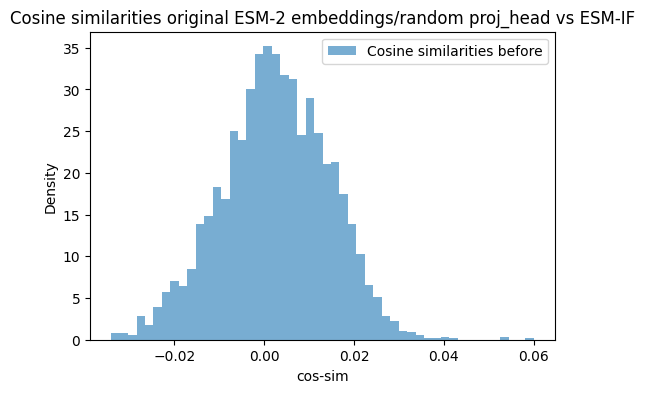

In [12]:
### Loading original embeddings and RANDOM projection head

_loader = DataLoader(meta_Dataset, batch_size=10)
original_embeds_random_head = []
seq_proj = nn.Linear(1280, 512).to("cuda")
padding_value = -5000.0

for batch in tqdm(_loader):
    seq_embed, seqs_list, struct_embed = batch
    seq_embed, struct_embed = seq_embed.to(device), struct_embed.to(device)

    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        # proj = model.seq_down(real_seq)      # [Li, 512]
        proj = seq_proj(real_seq)
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls


    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    original_embeds_random_head.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(original_embeds_random_head, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities original ESM-2 embeddings/random proj_head vs ESM-IF")
plt.legend()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 355/355 [00:07<00:00, 45.91it/s]


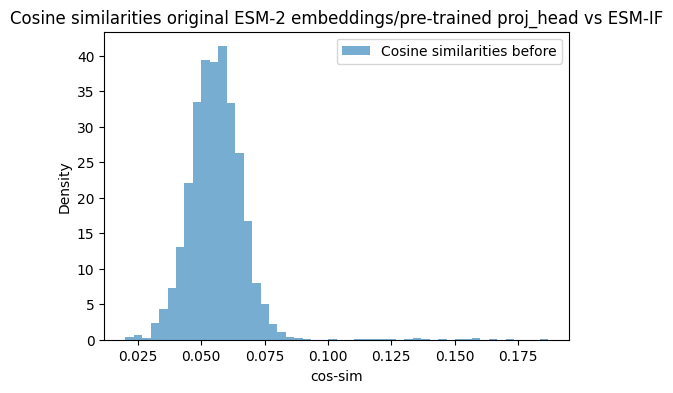

In [13]:
### Loading original embeddings and PRE-TRAINED projection head

_loader = DataLoader(meta_Dataset, batch_size=10)
original_embeds_pretrained_head_ep1 = []

for batch in tqdm(_loader):
    seq_embed, seqs_list, struct_embed = batch
    seq_embed, struct_embed = seq_embed.to(device), struct_embed.to(device)

    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        # proj = seq_proj(real_seq)
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls


    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    original_embeds_pretrained_head_ep1.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(original_embeds_pretrained_head_ep1, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similarities original ESM-2 embeddings/pre-trained proj_head vs ESM-IF")
plt.legend()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 355/355 [01:07<00:00,  5.29it/s]


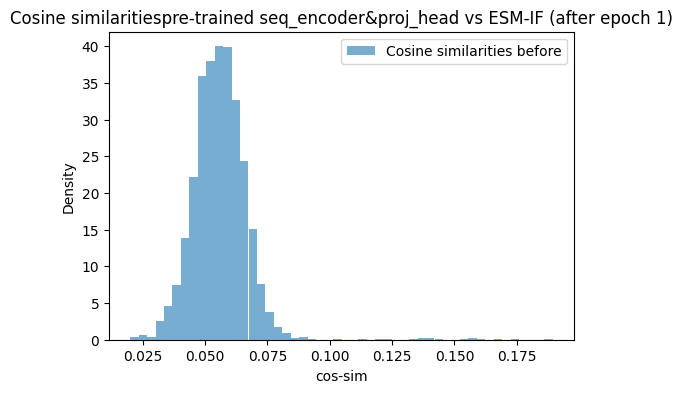

In [14]:
### PRE-TRAINED seq_encoder and seq_down

_loader = DataLoader(meta_Dataset, batch_size=10)
pretrained_encoder_head_ep1 = []

for batch in tqdm(_loader):
    ___, seqs_list, struct_embed = batch
    struct_embed = struct_embed.to(device)

    seq_embed = seq_encoder(seqs_list)
    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls


    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    pretrained_encoder_head_ep1.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(pretrained_encoder_head_ep1, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similaritiespre-trained seq_encoder&proj_head vs ESM-IF (after epoch 1)")
plt.legend()
plt.show()

#### Checkpoint after epoch 5

In [15]:
### Training seq_down for 5 epoch 
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/4334cb1c-12f0-4fa2-982c-da9f78779bee/seq_encoder_5.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location=device)
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/4334cb1c-12f0-4fa2-982c-da9f78779bee/seq_down_5.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location=device)
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)
# seq_down.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=512, bias=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 355/355 [01:07<00:00,  5.26it/s]


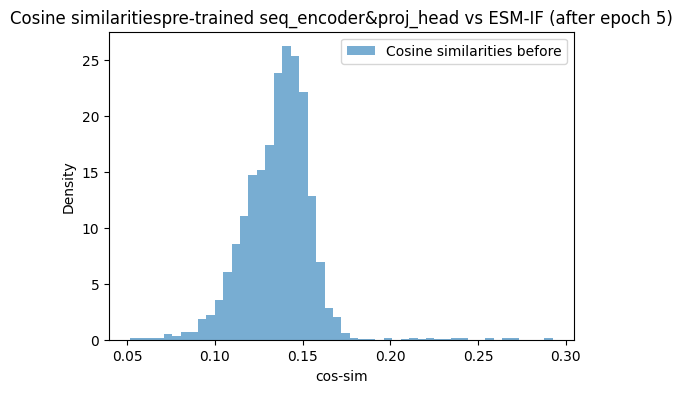

In [16]:
### PRE-TRAINED seq_encoder and seq_down

_loader = DataLoader(meta_Dataset, batch_size=10)
pretrained_encoder_head_ep5 = []

for batch in tqdm(_loader):
    ___, seqs_list, struct_embed = batch
    struct_embed = struct_embed.to(device)

    seq_embed = seq_encoder(seqs_list)
    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls


    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    pretrained_encoder_head_ep5.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(pretrained_encoder_head_ep5, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similaritiespre-trained seq_encoder&proj_head vs ESM-IF (after epoch 5)")
plt.legend()
plt.show()

#### Checkpoint after epoch 50

In [17]:
### Training seq_down for 50 epoch 
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/4334cb1c-12f0-4fa2-982c-da9f78779bee/seq_encoder_50.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location=device)
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

# seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/4334cb1c-12f0-4fa2-982c-da9f78779bee/seq_down_50.pt"
# seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location=device)
# seq_down = nn.Linear(1280, 512)
# seq_down.load_state_dict(seq_down_state_dict)
# seq_down.to(device)
# # seq_down.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/4334cb1c-12f0-4fa2-982c-da9f78779bee/seq_down_5.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location=device)
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)
# seq_down.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=512, bias=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 355/355 [01:07<00:00,  5.25it/s]


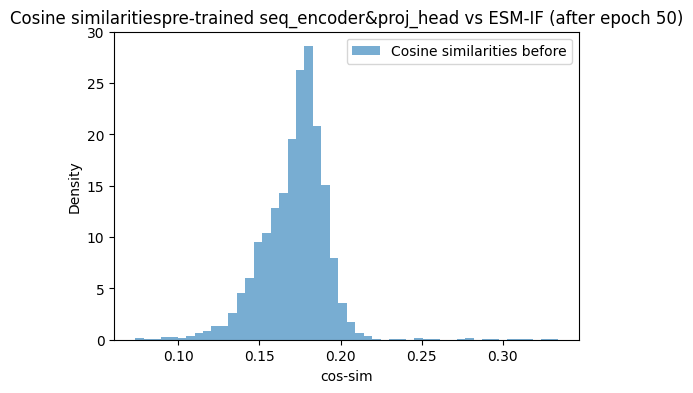

In [18]:
### PRE-TRAINED for 50 epochs seq_encoder and seq_down

_loader = DataLoader(meta_Dataset, batch_size=10)
pretrained_encoder_head_ep50 = []

for batch in tqdm(_loader):
    ___, seqs_list, struct_embed = batch
    struct_embed = struct_embed.to(device)

    seq_embed = seq_encoder(seqs_list)
    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls


    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    pretrained_encoder_head_ep50.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(pretrained_encoder_head_ep50, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similaritiespre-trained seq_encoder&proj_head vs ESM-IF (after epoch 50)")
plt.legend()
plt.show()

#### Checkpoint cos-sim 0.20

In [19]:
### Training seq_down for 60 epoch 
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/39c990f3-0db5-430a-8095-075f38a5e808/seq_encoder_cos-sim0.2.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location="cuda")
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/39c990f3-0db5-430a-8095-075f38a5e808/seq_down_cos-sim0.2.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location="cuda")
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)
# seq_down.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=512, bias=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 355/355 [01:07<00:00,  5.26it/s]


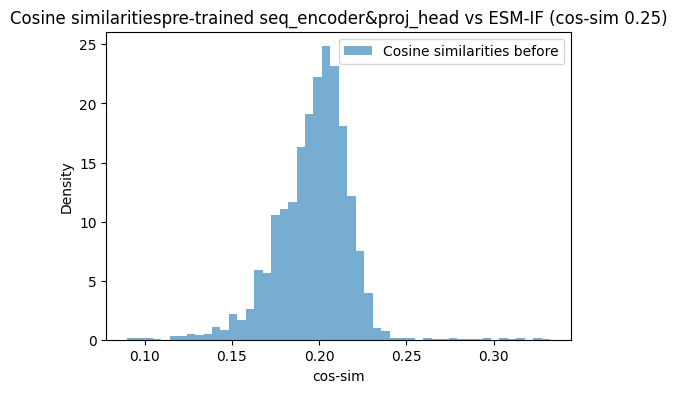

In [20]:
_loader = DataLoader(meta_Dataset, batch_size=10)
pretrained_encoder_head_cos_sim0_2= []

for batch in tqdm(_loader):
    ___, seqs_list, struct_embed = batch
    struct_embed = struct_embed.to(device)

    seq_embed = seq_encoder(seqs_list)
    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls


    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    pretrained_encoder_head_cos_sim0_2.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(pretrained_encoder_head_cos_sim0_2, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similaritiespre-trained seq_encoder&proj_head vs ESM-IF (cos-sim 0.20)")
plt.legend()
plt.show()

#### Checkpoint cos-sim 0.25

In [21]:
### Training seq_down for 60 epoch 
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/39c990f3-0db5-430a-8095-075f38a5e808/seq_encoder_cos-sim0.25.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location="cuda")
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/39c990f3-0db5-430a-8095-075f38a5e808/seq_down_cos-sim0.25.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location="cuda")
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)
# seq_down.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=512, bias=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 355/355 [01:07<00:00,  5.27it/s]


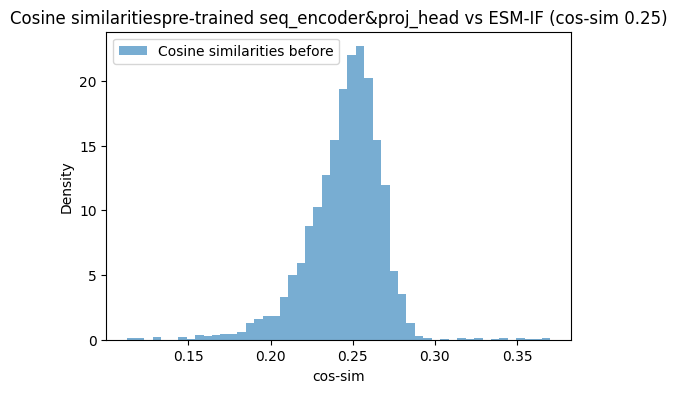

In [22]:
### PRE-TRAINED for 60 epochs seq_encoder and seq_down

_loader = DataLoader(meta_Dataset, batch_size=10)
pretrained_encoder_head_cos_sim0_25= []

for batch in tqdm(_loader):
    ___, seqs_list, struct_embed = batch
    struct_embed = struct_embed.to(device)

    seq_embed = seq_encoder(seqs_list)
    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls


    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    pretrained_encoder_head_cos_sim0_25.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(pretrained_encoder_head_cos_sim0_25, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similaritiespre-trained seq_encoder&proj_head vs ESM-IF (cos-sim 0.25)")
plt.legend()
plt.show()

#### Checkpoint cos-sim 0.30

In [24]:
### Training seq_down for 60 epoch 
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/39c990f3-0db5-430a-8095-075f38a5e808/seq_encoder_cos-sim0.3.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location="cuda")
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/39c990f3-0db5-430a-8095-075f38a5e808/seq_down_cos-sim0.3.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location="cuda")
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)
# seq_down.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=512, bias=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 355/355 [01:07<00:00,  5.28it/s]


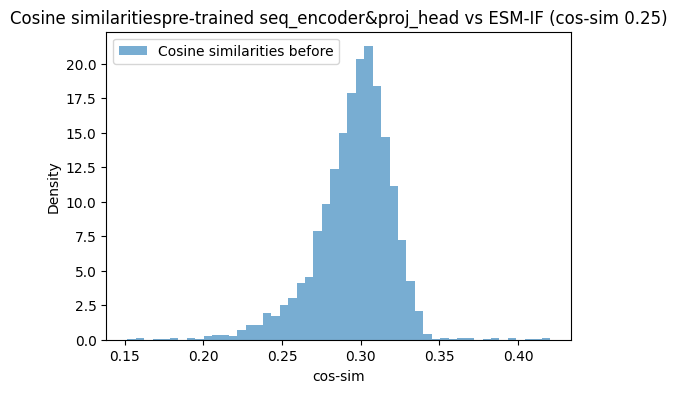

In [25]:
### PRE-TRAINED for 60 epochs seq_encoder and seq_down

_loader = DataLoader(meta_Dataset, batch_size=10)
pretrained_encoder_head_cos_sim0_30= []

for batch in tqdm(_loader):
    ___, seqs_list, struct_embed = batch
    struct_embed = struct_embed.to(device)

    seq_embed = seq_encoder(seqs_list)
    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls


    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    pretrained_encoder_head_cos_sim0_30.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(pretrained_encoder_head_cos_sim0_30, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similaritiespre-trained seq_encoder&proj_head vs ESM-IF (cos-sim 0.30)")
plt.legend()
plt.show()

#### Checkpoint cos-sim 0.35

In [26]:
### Training seq_down for 60 epoch 
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/39c990f3-0db5-430a-8095-075f38a5e808/seq_encoder_cos-sim0.35.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location="cuda")
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to(device)
seq_encoder.eval()

seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint/39c990f3-0db5-430a-8095-075f38a5e808/seq_down_cos-sim0.35.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location="cuda")
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to(device)
# seq_down.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=512, bias=True)

100%|█████████████████████████████████████████████████████████████████████████████████| 355/355 [01:07<00:00,  5.27it/s]


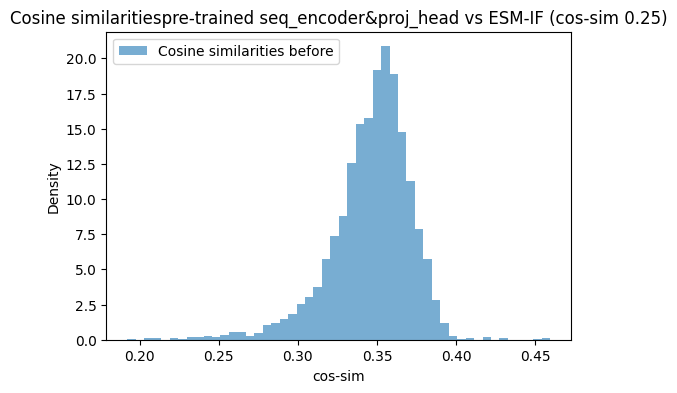

In [27]:
### PRE-TRAINED for 60 epochs seq_encoder and seq_down

_loader = DataLoader(meta_Dataset, batch_size=10)
pretrained_encoder_head_cos_sim0_35= []

for batch in tqdm(_loader):
    ___, seqs_list, struct_embed = batch
    struct_embed = struct_embed.to(device)

    seq_embed = seq_encoder(seqs_list)
    B, Lq, _ = seq_embed.shape
    _, Ls, Ds = struct_embed.shape

    seq_mask = non_padding_mask(seq_embed, padding_value)   # [B, Lq]
    str_mask = non_padding_mask(struct_embed, padding_value)  # [B, Ls]

    # enforce residue-wise alignment
    # print(seq_mask.sum(dim=1).cpu().tolist())
    # print(str_mask.sum(dim=1).cpu().tolist())
    assert (seq_mask.sum(dim=1).cpu().tolist()== str_mask.sum(dim=1).cpu().tolist())

    # ---- project seq tokens + pad to structure length ----
    seq_embed_proj = torch.full((B, Ls, Ds), padding_value, device=seq_embed.device, dtype=seq_embed.dtype)
    
    for i in range(B):
        real_seq = seq_embed[i][seq_mask[i]]      # [Li, 1280]
        proj = seq_down(real_seq)      # [Li, 512]
        seq_embed_proj[i, :proj.size(0)] = proj   # pad up to Ls


    # ---- token-level cosine similarity (aligned positions) ----
    cos = F.cosine_similarity(seq_embed_proj, struct_embed, dim=-1)  # [B, Ls]
    cos = cos * str_mask.float()   # mask padding

    per_seq_cos = cos.sum(dim=1) / str_mask.sum(dim=1)
    pretrained_encoder_head_cos_sim0_35.extend(per_seq_cos.cpu().tolist())

plt.figure(figsize=(6, 4))
plt.hist(pretrained_encoder_head_cos_sim0_35, bins=50, alpha=0.6, label="Cosine similarities before", density=True)
# plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("cos-sim")
plt.ylabel("Density")
plt.title("Cosine similaritiespre-trained seq_encoder&proj_head vs ESM-IF (cos-sim 0.35)")
plt.legend()
plt.show()

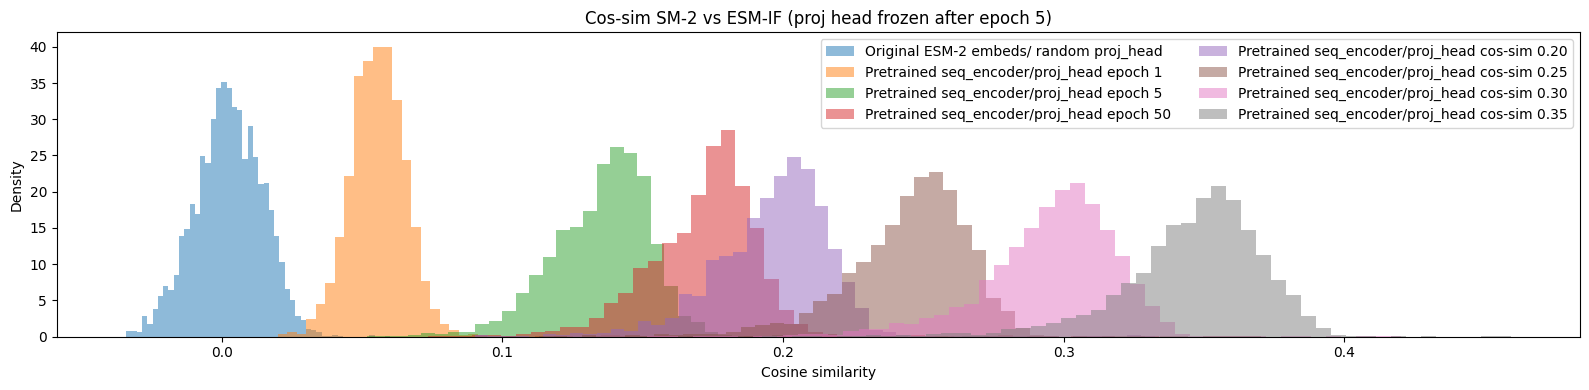

In [31]:
plt.figure(figsize=(16, 4))

plt.hist(original_embeds_random_head, bins=50, alpha=0.5,
         label="Original ESM-2 embeds/ random proj_head", density=True)

# plt.hist(original_embeds_pretrained_head_ep1, bins=50, alpha=0.5,
#          label="Original embeds (pretrained head)", density=True)

plt.hist(pretrained_encoder_head_ep1, bins=50, alpha=0.5,
         label="Pretrained seq_encoder/proj_head epoch 1 ", density=True)

plt.hist(pretrained_encoder_head_ep5, bins=50, alpha=0.5,
         label="Pretrained seq_encoder/proj_head epoch 5 ", density=True)

plt.hist(pretrained_encoder_head_ep50, bins=50, alpha=0.5,
         label="Pretrained seq_encoder/proj_head epoch 50", density=True)

plt.hist(pretrained_encoder_head_cos_sim0_2, bins=50, alpha=0.5,
         label="Pretrained seq_encoder/proj_head cos-sim 0.20", density=True)

plt.hist(pretrained_encoder_head_cos_sim0_25, bins=50, alpha=0.5,
         label="Pretrained seq_encoder/proj_head cos-sim 0.25", density=True)

plt.hist(pretrained_encoder_head_cos_sim0_30, bins=50, alpha=0.5,
         label="Pretrained seq_encoder/proj_head cos-sim 0.30", density=True)

plt.hist(pretrained_encoder_head_cos_sim0_35, bins=50, alpha=0.5,
         label="Pretrained seq_encoder/proj_head cos-sim 0.35", density=True)

plt.xlabel("Cosine similarity")
plt.ylabel("Density")
plt.title("Cos-sim SM-2 vs ESM-IF (proj head frozen after epoch 5)")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()